In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from types import SimpleNamespace

import pySPEC as ps
from pySPEC.time_marching import SWHD_1D, Adjoint_SWHD_1D

param_path = 'examples/adjoint'
# Parse JSON into an object with attributes corresponding to dict keys.
fpm = json.load(open(f'{param_path}/forward_params.json', 'r'), object_hook=lambda d: SimpleNamespace(**d))
bpm = json.load(open(f'{param_path}/backward_params.json', 'r'), object_hook=lambda d: SimpleNamespace(**d))
fpm.Lx = 2*np.pi*fpm.Lx
grid   = ps.Grid1D(fpm)


In [11]:
dgs = [np.load(f'{fpm.hb_path}/dg_{ii}.npy') for ii in range(1,1)] # only t = 0 h_ux
Nt = round(fpm.T/fpm.dt)
h_uxs =  [np.load(f'{bpm.out_path}/h_ux_{step:04}.npy') for step in range(Nt)] # all t h_ux
hx_uus =  [np.load(f'{bpm.out_path}/hx_uu_{step:04}.npy') for step in range(Nt)] # all t hx_uu
h_uxs_non_dealiased =  [np.load(f'{bpm.out_path}/h_ux_non_dealiased{step:04}.npy') for step in range(Nt)] # all t h_ux


In [4]:
def get_dg_stats(h_uxs):
    # h_ux mean and max
    mh_uxs = [h_ux.mean() for h_ux in h_uxs]
    Mh_uxs = [h_ux.max() for h_ux in h_uxs]
    # argmaxh_ux =  np.argmax(np.array(mh_uxs))
    # maxh_ux =  np.array(mh_uxs).max()
    # integrate h_ux in time
    Th_uxs = np.trapz(np.array(h_uxs), dx = -1e-4, axis = 0) # -dt because integration is from T to t=0
    print('check shape of integral h_ux :  ' , Th_uxs.shape)
    # integrate h_ux in time and space
    XTh_uxs = np.trapz(Th_uxs ,  dx = 2*np.pi/len(Th_uxs))
    print('integral in space-time h_ux = ', XTh_uxs)
    return mh_uxs, Mh_uxs, Th_uxs, XTh_uxs

In [13]:
mh_uxs, Mh_uxs, Th_uxs, XTh_uxs = get_dg_stats(h_uxs)
mh_uxs_non,  Mh_uxs_non , Th_uxs_non, XTh_uxs_non = get_dg_stats(h_uxs_non_dealiased)
mhx_uus,  Mhx_uus , Thx_uus, XThx_uus = get_dg_stats(hx_uus)

tts = [tt for tt in range(len(h_uxs))]

# get uu for argmaxh_ux
argmaxh_ux =  np.argmax(np.array(mh_uxs))
maxh_ux =  np.array(mh_uxs).max()
# load
hh_max = np.load(f'{fpm.data_path}/hh_{argmaxh_ux:04}.npy')
hb = np.load(f'{fpm.data_path}/hb.npy')


check shape of integral h_ux :   (1024,)
integral in space-time h_ux =  -0.0016404598332546549
check shape of integral h_ux :   (1024,)
integral in space-time h_ux =  -0.0016314188486405172
check shape of integral h_ux :   (1024,)
integral in space-time h_ux =  0.001631412630636138


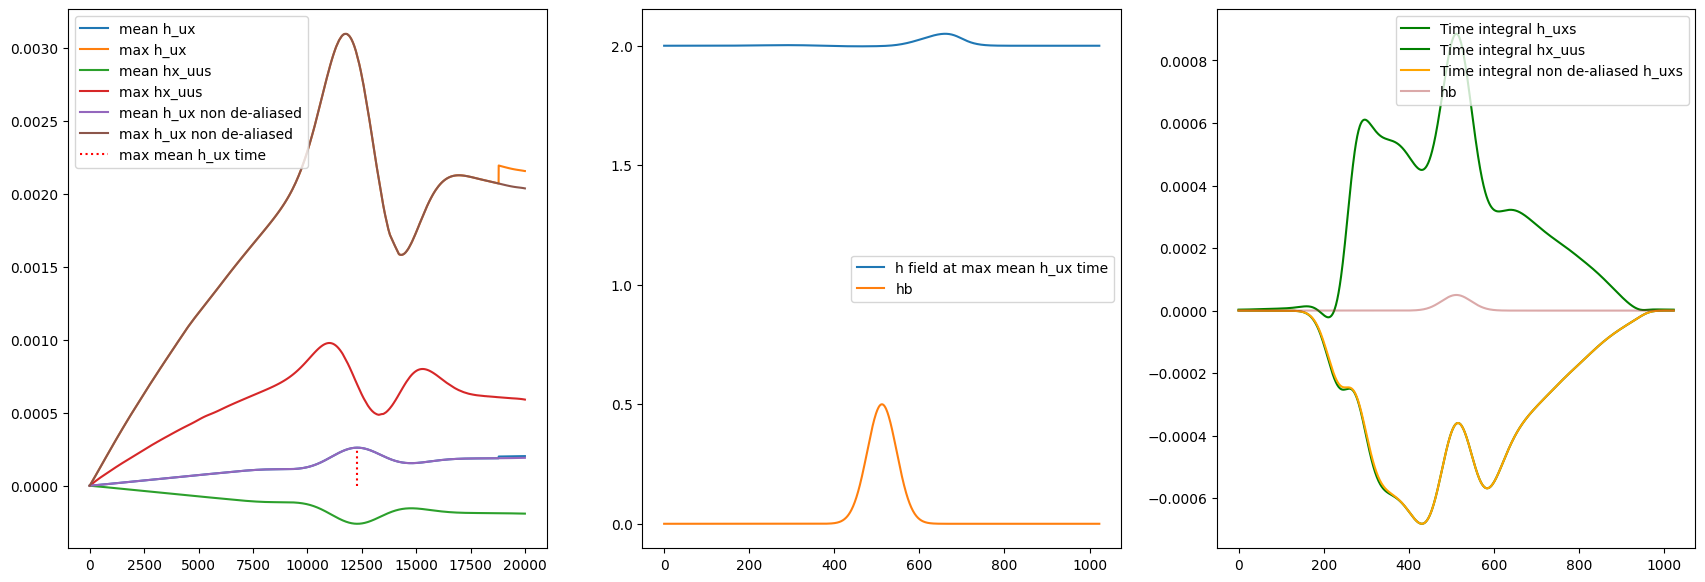

In [16]:
f,axs = plt.subplots(ncols=3 , figsize = (21,7))

axs[0].plot(tts , mh_uxs , label = 'mean h_ux' )
axs[0].plot(tts , Mh_uxs , label = 'max h_ux' )
axs[0].plot(tts , mhx_uus , label = 'mean hx_uus' )
axs[0].plot(tts , Mhx_uus , label = 'max hx_uus' )
axs[0].plot(tts , mh_uxs_non , label = 'mean h_ux non de-aliased' )
axs[0].plot(tts , Mh_uxs_non , label = 'max h_ux non de-aliased' )
axs[0].vlines(argmaxh_ux , 0 , maxh_ux, linestyles='dotted', color = 'red', label = 'max mean h_ux time')
axs[0].legend()

axs[1].plot(hh_max, label = 'h field at max mean h_ux time')
axs[1].plot(hb, label = 'hb')
axs[1].legend()

axs[2].plot(Th_uxs , alpha = 1, color = 'green' , label = 'Time integral h_uxs')
axs[2].plot(Thx_uus , alpha = 1, color = 'green' , label = 'Time integral hx_uus')
axs[2].plot( Th_uxs_non , alpha = 1, color = 'orange' ,label = 'Time integral non de-aliased h_uxs')
# axs[2].plot(hh_max, label = 'h field at max mean h_ux time' , alpha = 0.4 , color = 'green')
# axs[2].plot(hb*1e-4, label = 'hb' , alpha = 0.4 , color = 'brown')
axs[2].legend()


zero modes for adjoint states

In [26]:
adjoint_zero_modes = [np.load(f'{bpm.out_path}/adjoint_zero_modes_{step:04}.npy') for step in range(Nt)] # zero modes for adjoint states

/home/lpancotto/.pyenv/versions/lewagon/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


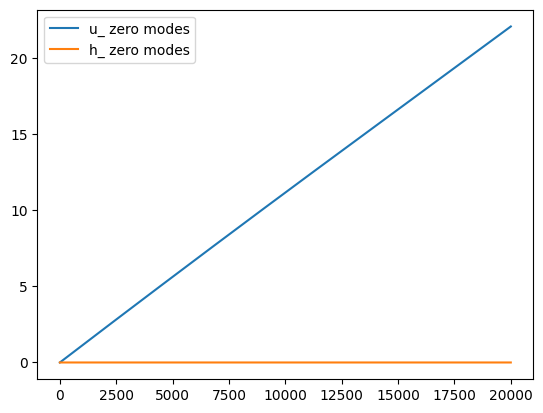

In [31]:
adjoint_zero_modes = np.array(adjoint_zero_modes)
adjoint_zero_modes.shape

plt.plot(adjoint_zero_modes[:,0] , label = 'u_ zero modes')
plt.plot(adjoint_zero_modes[:,1] , label = 'h_ zero modes')
plt.legend()